# Анализ данных о продажах в онлайн-ритейле.
## Цели исследования:

- Посмотреть на распределения и выбрать меры центральной тенденции для различных показателей, чтобы иметь представление о ключевых метриках.

- Найти взаимосвязи различных показателей между собой, чтобы понять, как и на какие метрики можно влиять.

- Проверить статистическую значимость различных гипотез.

## Описание данных:
- InvoiceNo - номер счета. Уникальный шестизначный номер, присваиваемый каждому счету. Если начинается с буквы 'С', значит - это отмена.
- StockCode - код товара. Уникальный пятизначный номер, присваиваемый каждому товару.
- Description - описание товара.
- Quantity - кол-во товаров в заказе.
- InvoiceDate - дата и время счета. Дата и время, когда был сформирован счет на оплату.
- UnitPrice - цена товара. Цена за единицу товара в фунтах стерлингов.
- CustomerID - номер пользователя. Уникальный пятизначный номер, присваиваемый каждому пользователю.
- Country - страна. Страна проживания пользователя.

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scipy.stats as ss
import pingouin as pg
from tqdm import tqdm

# 1. Знакомство с данными.
Для начала посмотрим на данные, их типы, наличие пропусков, при необходимости скорректируем, приведем в более комфортный вид/формат.

In [2]:
# Запишем путь к данным в переменную

path_to_file = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Va5LBeyd3A53RA'

In [3]:
# Считаем данные в датасет

df = pd.read_csv(path_to_file)

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Из структуры данных видно, что каждая строка отвечает за один товар в заказе, целый заказ может занимать несколько строк, а номера счетов, время и id пользователей здесь не только уникальные, но и дубликаты.

In [5]:
# Приведем названия колонок к snake_case

df.columns = df.columns.str.lower()

In [6]:
# Переведем колонку с датой и временем к типу datetime

df.invoicedate = pd.to_datetime(df.invoicedate)

In [7]:
# ID пользователей должен быть целым числом,
# но лучше его сразу перевести в string,
# например, чтобы не было соблазна по ошибке посчитать сумму

df.loc[df.customerid.notna(), 
               'customerid'] = df.loc[df.customerid.notna(), 
                                      'customerid'] \
                                 .astype('string') \
                                 .str.split('.') \
                                 .apply(lambda x: x[0])

In [8]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [9]:
# Посмотрим на типы, кол-во данных, наличие пропусков

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  540455 non-null  object        
 3   quantity     541909 non-null  int64         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float64       
 6   customerid   406829 non-null  object        
 7   country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
# Посмотрим на пропуски в описаниях

df[df.description.isna()].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [11]:
df[df.description.isna()].unitprice.describe()

count    1454.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: unitprice, dtype: float64

Похоже, что пропуск в описании означает отмененный продавцом заказ, т.к. в качестве цены везде указан ноль. Получается, что заказы с 'С' в начале - это заказы отмененные покупателем.

In [12]:
# Посмотрим на пропуски в id пользователей

df[df.customerid.isna()].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


Судя по всему, чтобы совершить покупку, нет необходимости регистрироваться, и это заказы незарегистрированных пользователей.

In [13]:
# Посмотрим на описательные характеристики

df.describe()

,quantity,unitprice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


<AxesSubplot:xlabel='quantity'>

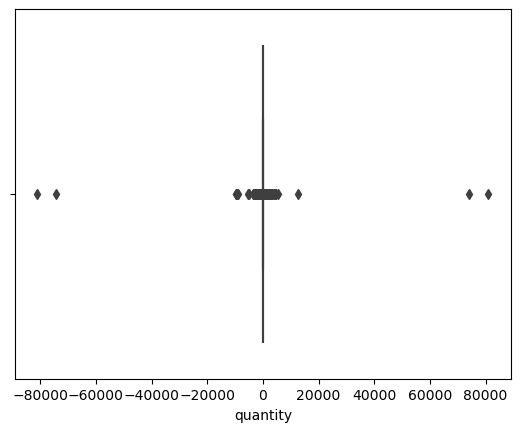

In [14]:
# Посмотрим на распределение кол-ва товаров

sns.boxplot(data=df, x='quantity')

<AxesSubplot:xlabel='quantity'>

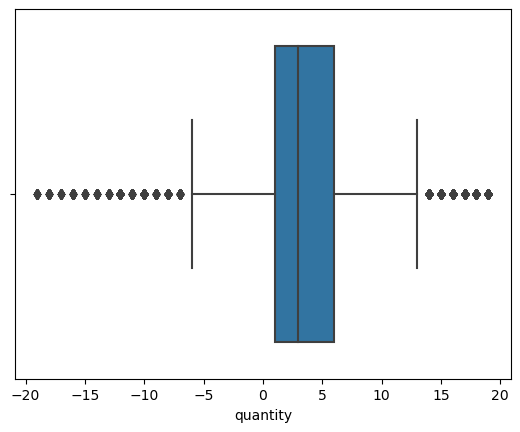

In [15]:
# Разброс значений очень большой, 
# приблизимся к центральной зоне

sns.boxplot(data=df[(df.quantity > -20)
                    & (df.quantity < 20)], x='quantity')

Возникает сразу несколько вопросов:
1. Что значит отрицательное кол-во?
2. Нет ли в данных ошибок, т.к. есть очень крупные на общем фоне заказы.

In [16]:
# Посмотрим на заказы с отрицательным кол-вом,
# есть ли среди них неотмененные

df[(df.quantity < 0) 
       & (df.invoiceno.str.startswith('C') == False)]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom


In [17]:
df[(df.quantity < 0) 
       & (df.invoiceno.str.startswith('C') == False)] \
            .unitprice.describe()

count    1336.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: unitprice, dtype: float64

Похоже, что заказы с отрицательным кол-вом и без сигнальной 'С' в начале Invoice No - это также отмененные продавцом заказы.

In [18]:
# Посмотрим на заказы, где кол-во превышает 15 шт.

df[(df.quantity > 15) 
       | (df.quantity < -15)] \
            .quantity.value_counts(normalize=True) \
            .mul(100) \
            .round(1) \
            .head(20)

24     34.1
48      8.6
25      7.3
20      7.1
16      6.0
36      5.4
72      2.8
100     2.6
96      2.6
18      2.5
30      1.7
40      1.5
32      1.5
144     1.4
50      1.3
60      1.0
120     0.9
200     0.6
192     0.5
64      0.4
Name: quantity, dtype: float64

Подавляющее большинство заказов с кол-вом более 15 шт. находится в пределах 200 шт., что выглядит вполне адекватно. Посмотрим на экстремальные значения отдельно.

In [19]:
df[(df.quantity > 5000) | (df.quantity < -5000)]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
74614,542504,37413,NaN,5568,2011-01-28 12:03:00,0.00,NaN,United Kingdom
115818,546152,72140F,throw away,-5368,2011-03-09 17:25:00,0.00,NaN,United Kingdom
225528,556687,23003,Printing smudges/thrown away,-9058,2011-06-14 10:36:00,0.00,NaN,United Kingdom
225529,556690,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


Похоже, что все эти заказы отменены.

<AxesSubplot:xlabel='unitprice'>

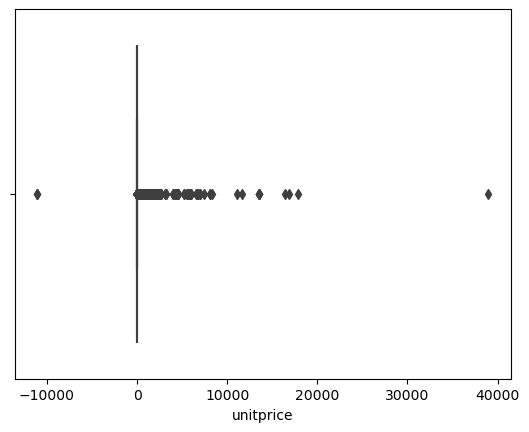

In [20]:
# Посмотрим на распределение цен

sns.boxplot(data=df, x='unitprice')

<AxesSubplot:xlabel='unitprice'>

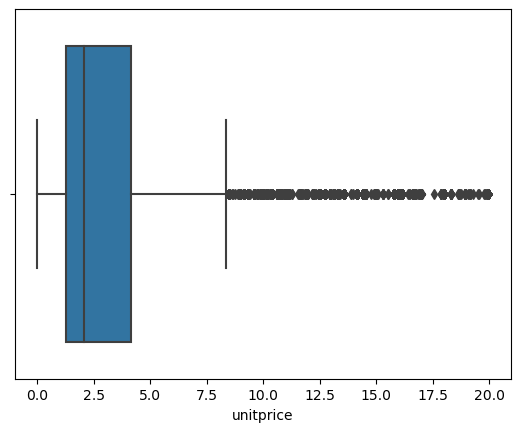

In [21]:
# Разброс значений очень большой, 
# приблизимся к центральной зоне

sns.boxplot(data=df[(df.unitprice < 20) & (df.unitprice > -20)], x='unitprice')

Вопросы к ценам те же:
1. Что означают отрицательные цены?
2. Не ошибочны ли эксремальные значения?

In [22]:
# Отрицательные цены

df[df.unitprice < 0]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


В данных есть заказы с номерами счета и кодом товара, несоотвутствующими первоначальному описанию.

In [23]:
# Посмотрим, какой длины бывают номера счетов

df.invoiceno.apply(len).value_counts()

6    532618
7      9291
Name: invoiceno, dtype: int64

In [24]:
# Какие еще варианты номеров счетов у нас есть, кроме известных?

df[(~(df.invoiceno.str.startswith('C')) 
     & (df.invoiceno.apply(len) == 7)) 
      | (((df.invoiceno.str.isdigit() == False) 
         & (df.invoiceno.apply(len) == 6)))]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Всего 3 номера, которые не подходят под описание.

In [25]:
# Посмотрим на коды товаров, которые не подходят под описание
# Без цифр

df[df.stockcode.str.isalpha()].stockcode.unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [26]:
# Какие у них описания?

df[df.stockcode.str.isalpha()].description.unique()

array(['POSTAGE', 'Discount', 'DOTCOM POSTAGE', 'Manual', 'SAMPLES',
       'AMAZON FEE', nan, 'BOYS PARTY BAG', 'GIRLS PARTY BAG',
       'PADS TO MATCH ALL CUSHIONS', 'Adjust bad debt', 'CRUK Commission'],
      dtype=object)

Из представленных описаний лишь несколько кажутся обычными товарами, посмотрим на них.

In [27]:
# Посмотрим на описания

df.query('description in ["PADS TO MATCH ALL CUSHIONS", \
                          "BOYS PARTY BAG", \
                          "GIRLS PARTY BAG"]')

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
84016,543358,DCGSSBOY,BOYS PARTY BAG,1,2011-02-07 14:04:00,3.290,NaN,United Kingdom
84017,543358,DCGSSGIRL,GIRLS PARTY BAG,3,2011-02-07 14:04:00,3.290,NaN,United Kingdom
97246,544599,DCGSSBOY,BOYS PARTY BAG,1,2011-02-21 18:15:00,3.290,NaN,United Kingdom
112723,545897,DCGSSBOY,BOYS PARTY BAG,5,2011-03-07 17:22:00,3.290,NaN,United Kingdom
112724,545897,DCGSSGIRL,GIRLS PARTY BAG,5,2011-03-07 17:22:00,3.290,NaN,United Kingdom
116891,546306,DCGSSBOY,BOYS PARTY BAG,1,2011-03-10 16:16:00,3.290,NaN,United Kingdom
116892,546306,DCGSSGIRL,GIRLS PARTY BAG,2,2011-03-10 16:16:00,3.290,NaN,United Kingdom
128107,547249,DCGSSBOY,BOYS PARTY BAG,6,2011-03-22 09:27:00,3.290,NaN,United Kingdom
128108,547249,DCGSSGIRL,GIRLS PARTY BAG,17,2011-03-22 09:27:00,3.290,NaN,United Kingdom
128269,547250,DCGSSGIRL,GIRLS PARTY BAG,2,2011-03-22 09:30:00,3.290,NaN,United Kingdom


У 2х типов описания нет id клиента, у другого - цена выглядит очень странно.

In [28]:
# Посмотрим на коды с длиной, отличной от базовой

df[~(df.stockcode.str[5].str.isalpha()
     & df.stockcode.str[:5].str.isdigit()
      & (df.stockcode.apply(len) == 6)) 
       & ~(df.stockcode.str.isdigit() 
        & (df.stockcode.apply(len) == 5))].description.unique()

array(['POSTAGE', 'EDWARDIAN PARASOL BLACK', 'Discount', 'CARRIAGE',
       'DOTCOM POSTAGE', 'Manual', 'Bank Charges', 'SAMPLES',
       'AMAZON FEE', 'SUNJAR LED NIGHT NIGHT LIGHT',
       'BOXED GLASS ASHTRAY', 'Dotcomgiftshop Gift Voucher £40.00',
       'CAMOUFLAGE DOG COLLAR', 'Dotcomgiftshop Gift Voucher £50.00',
       'Dotcomgiftshop Gift Voucher £30.00',
       'Dotcomgiftshop Gift Voucher £20.00', nan, 'OOH LA LA DOGS COLLAR',
       'BOYS PARTY BAG', 'GIRLS PARTY BAG',
       'Dotcomgiftshop Gift Voucher £10.00', 'PADS TO MATCH ALL CUSHIONS',
       'HAYNES CAMPER SHOULDER BAG',
       'to push order througha s stock was ', 'ebay', 'Adjust bad debt',
       'CRUK Commission', 'Unsaleable, destroyed.'], dtype=object)

Из представленных описаний лишь несколько кажутся обычными товарами, посмотрим на них.

In [29]:
df.query('description in ["HAYNES CAMPER SHOULDER BAG", \
                          "OOH LA LA DOGS COLLAR", \
                          "CAMOUFLAGE DOG COLLAR", \
                          "BOXED GLASS ASHTRAY", \
                          "SUNJAR LED NIGHT NIGHT LIGHT", \
                          "EDWARDIAN PARASOL BLACK"]') \
                                .groupby('description') \
                                .agg({'quantity': 'sum', 'unitprice': 'min'})

,quantity,unitprice
description,,
BOXED GLASS ASHTRAY,4,2.46
CAMOUFLAGE DOG COLLAR,1,12.72
EDWARDIAN PARASOL BLACK,2801,1.95
HAYNES CAMPER SHOULDER BAG,1,16.63
OOH LA LA DOGS COLLAR,1,15.79
SUNJAR LED NIGHT NIGHT LIGHT,3,16.13


С этими товарами все ОК.

ИТОГО:

1. Если у товара нет описания и/или в графе цена стоит 0 и/или кол-во отрицательное при отсутствии "С" в номере счета - это отмененный продавцом заказ. Мы не будем их учитывать при дальнейшей работе, но посчитаем их долю, чтобы иметь общее представление о масштабе.
2. Есть заказы с экстремальными значениями кол-ва. Все они отменены. Мы уберем эти выбросы, т.к. вероятней всего - это ошибки или фрод, при этом они будут сильно влиять на распределение, т.е. на среднее и статистические тесты.
3. Есть заказы с отрицательными ценами и странным кодом. Это отмены. Уберем их из данных, т.к. неизвестно что это.
4. Есть коды товаров, которые не подходят под описание. Среди них неопределенные платы, комиссии, ваучеры и проч. Их также уберем из данных.

In [76]:
# Почистим ДФ от п.п.2-4

clean_df = df[((df.quantity < 5000) 
               & (df.quantity > -5000))     # убираем экстремальные объемы
                & ~(df.stockcode.str.isalpha())      # убираем текстовые коды
                 & ((df.stockcode.str[5].str.isalpha()
                  & df.stockcode.str[:5].str.isdigit()
                   & (df.stockcode.apply(len) == 6))     # оставляем правильные коды
                    | (df.stockcode.str.isdigit() 
                     & (df.stockcode.apply(len) == 5))     # оставляем правильные коды
                      | df.description     
                           .isin(["HAYNES CAMPER SHOULDER BAG", \
                                  "OOH LA LA DOGS COLLAR", \
                                  "CAMOUFLAGE DOG COLLAR", \
                                  "BOXED GLASS ASHTRAY", \
                                  "SUNJAR LED NIGHT NIGHT LIGHT", \
                                  "EDWARDIAN PARASOL BLACK"]))]     # оставляем правильные описания

Мы изучили и почистили данные и готовы к дальнейшей работе.